In [1]:
import cv2 
from matplotlib import pyplot as plt

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import random
import os
import csv
import cv2
from frame import FLCDataset, visualize_transformed_image


In [3]:
train_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_dataset_train.csv", r"C:\Users\lucyc\Desktop\face_loc_d")
val_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_dataset_val.csv", r"C:\Users\lucyc\Desktop\face_loc_d")
test_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_dataset_test.csv", r"C:\Users\lucyc\Desktop\face_loc_d")

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4)

In [4]:
a, b, c = next(iter(val_loader))

In [5]:
a.shape

torch.Size([128, 3, 12, 12])

In [6]:
def get_args(b):
    return [int(float(x)//1) for x in b.split()]

In [7]:
#visualize_transformed_image(a[6],get_args(b[6]),get_args(b[6]))

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
torch.cuda.empty_cache()

cuda:0


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PNet(nn.Module):
    def __init__(self):
        super(PNet, self).__init__()

        # Define network layers
        self.conv1 = nn.Conv2d(3, 10, 3)  # Input: 12x12x3, output: 10x10x10
        self.conv2 = nn.Conv2d(10, 16, 3) # Input: 5x5x10, output: 3x3x16
        self.conv3 = nn.Conv2d(16, 32, 3) # Input: 3x3x16, output: 1x1x32

        self.face_det = nn.Conv2d(32, 2, 1)  # face/not face classification
        self.bbox = nn.Conv2d(32, 4, 1)      # bounding box regression
        self.landmark = nn.Conv2d(32, 10, 1) # landmark localization

    def forward(self, x):
        # Forward pass
        x = F.relu(self.conv1(x))    # Activation following first convolution
        x = F.max_pool2d(x, 2)       # Max pooling (reducing spatial size to 5x5)
        x = F.relu(self.conv2(x))    # Activation following second convolution
        x = F.relu(self.conv3(x))    # Activation following third convolution

        # Applying convolution layers to the last feature map for different task
        facedet = self.face_det(x)   # Face detection
        bbox = self.bbox(x)          # Bounding box regression
        landmark = self.landmark(x)  # Landmark detection

        print(facedet.shape, bbox.shape, landmark.shape)

        # Reshape the output tensors to remove extra dimensions
        facedet = facedet.view(facedet.size(0), -1)  # Reshape to (N, 2)
        bbox = bbox.view(bbox.size(0), -1)           # Reshape to (N, 4)
        landmark = landmark.view(landmark.size(0), -1)  # Reshape to (N, 10)

        return facedet, bbox, landmark




In [10]:
class RNet(nn.Module):

    def __init__(self):
        super(RNet, self).__init__()

        # 定义网络层
        self.conv1 = nn.Conv2d(3, 28, 3)  #24 -> 22 -> maxp -> 11
        self.conv2 = nn.Conv2d(28, 48, 3) #11 -> 9 -> maxp -> 4
        self.conv3 = nn.Conv2d(48, 64, 2) #4 -> 3

        self.linear1 = nn.Linear(64*3*3, 128)

        self.face_det = nn.Linear(128, 2)
        self.bbox = nn.Linear(128, 4)
        self.landmark = nn.Linear(128, 10)

    def forward(self, x):
        # 定义前向传播
        x = F.relu(self.conv1(x)) #22
        x = F.max_pool2d(x, 2) #11
        x = F.relu(self.conv2(x)) #9
        x = F.max_pool2d(x, 2) #4
        x = F.relu(self.conv3(x)) #3

        x = x.view(-1, 64*3*3)
        x = F.relu(self.linear1(x))

        facedet = self.face_det(x)
        bbox = self.bbox(x)
        landmark = self.landmark(x)

        return facedet, bbox, landmark


In [11]:
losscrs = torch.nn.CrossEntropyLoss()
class RNetLoss(nn.Module):
    def __init__(self):
        super(RNetLoss, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)

        face = torch.tensor([1.0, 0.0], device=device)
        not_face = torch.tensor([0.0, 1.0], device=device)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype in ["2", "3", "4"]:
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([1], device=device))

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([0], device=device))

                bbox_loss = F.mse_loss(bbox[i], label[i][:4])

                loss_total = loss_total + (0.5 * bbox_loss + facedet_loss)

            elif ltype == "5":
                # 对于类型3，计算关键点损失
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([0], device=device))

                landmark_loss =F.mse_loss(landmark[i], label[i])
                
                loss_total = loss_total + (1 * landmark_loss + facedet_loss)

        loss_total = loss_total / len(ltypes)
        #loss_total = loss_total
        return loss_total

In [12]:
losscrs = torch.nn.CrossEntropyLoss()
class PNetLoss(nn.Module):
    def __init__(self):
        super(PNetLoss, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)

        face = torch.tensor([1.0, 0.0], device=device)
        not_face = torch.tensor([0.0, 1.0], device=device)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype in ["2", "3", "4"]:
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([1], device=device))

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([0], device=device))

                bbox_loss = F.mse_loss(bbox[i], label[i][:4])

                loss_total = loss_total + (0.5 * bbox_loss + facedet_loss)

            elif ltype == "5":
                # 对于类型3，计算关键点损失
                facedet_loss = losscrs(facedet[i].unsqueeze(0), torch.tensor([0], device=device))

                landmark_loss =F.mse_loss(landmark[i], label[i])
                
                loss_total = loss_total + (1 * landmark_loss + facedet_loss)

        loss_total = loss_total / len(ltypes)
        #loss_total = loss_total
        return loss_total

In [13]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = PNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = PNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


PNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (face_det): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (bbox): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  (landmark): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
)


In [14]:
training_loss = []
validation_loss = []

for i in range(20):
    model.train()  # 设置模型为训练模式

    train_x = []
    train_loss_y = []

    train_loss_acc = 0.
    train_num = 0

    for inputs in train_loader:
        
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        print(facedet.shape, bbox.shape, landmark.shape, label.shape, ltypes)
        optimizer.zero_grad()  # 清除之前的梯度
        loss = criterion(facedet, bbox, landmark, label, ltypes)
        # 反向传播和优化
        loss.backward()  # 反向传播计算当前的梯度
        optimizer.step()  # 更新参数

        train_loss_acc += loss.item()
        train_num += 1

        train_x.append(train_num)
        train_loss_y.append(loss.item())
        
        print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*128, len(train_dataset), i)
    
    training_loss.append((train_x, train_loss_y))

    model.eval()  # 设置模型为评估/测试模式

    val_loss_acc = 0
    val_num = 0
    with torch.no_grad():
        for inputs in val_loader:
            img_tensor = inputs[0].to(device)
            label = inputs[1].to(device)
            ltypes = inputs[2]

            facedet, bbox, landmark = model(img_tensor)
            loss = criterion(facedet, bbox, landmark, label, ltypes)

            val_loss_acc += loss.item()
            val_num += 1

            print(val_num,loss.item(),val_loss_acc/val_num, val_num*128, len(val_dataset))
    
    validation_loss.append(val_loss_acc/val_num)
        

        
    

torch.Size([128, 2, 1, 1]) torch.Size([128, 4, 1, 1]) torch.Size([128, 10, 1, 1])
torch.Size([128, 2]) torch.Size([128, 4]) torch.Size([128, 10]) torch.Size([128, 10]) ('1', '3', '2', '1', '3', '3', '0', '5', '4', '5', '3', '0', '3', '2', '0', '1', '2', '5', '1', '1', '3', '4', '3', '0', '5', '3', '2', '3', '0', '3', '3', '0', '5', '4', '2', '2', '3', '3', '3', '0', '0', '3', '1', '0', '2', '0', '4', '5', '2', '2', '0', '2', '2', '5', '4', '1', '3', '2', '1', '2', '4', '1', '4', '3', '0', '2', '3', '1', '0', '1', '4', '2', '3', '2', '4', '5', '1', '5', '5', '5', '3', '1', '2', '5', '3', '5', '3', '3', '1', '5', '3', '3', '4', '3', '0', '2', '1', '0', '1', '1', '1', '4', '3', '5', '5', '1', '1', '1', '0', '4', '4', '1', '0', '1', '4', '0', '1', '1', '0', '2', '1', '5', '3', '1', '3', '0', '2', '2')
1 16.20901870727539 0.08104509353637696 128 178783 0
torch.Size([128, 2, 1, 1]) torch.Size([128, 4, 1, 1]) torch.Size([128, 10, 1, 1])
torch.Size([128, 2]) torch.Size([128, 4]) torch.Size([12

KeyboardInterrupt: 

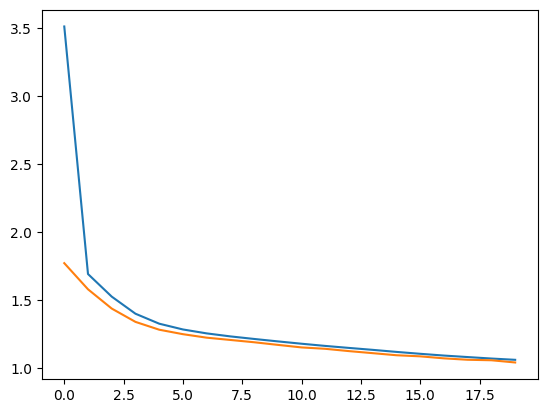

In [21]:
validation_loss
train_loss = [sum(x[1])/len(x[1]) for x in training_loss]
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()


In [20]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

#model = RNet()
model = torch.load(r"C:\Users\lucyc\Desktop\MTCNN_FaceLoc\src\face_loc_r_40.pth")
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = RNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


RNet(
  (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(48, 64, kernel_size=(2, 2), stride=(1, 1))
  (linear1): Linear(in_features=576, out_features=128, bias=True)
  (face_det): Linear(in_features=128, out_features=2, bias=True)
  (bbox): Linear(in_features=128, out_features=4, bias=True)
  (landmark): Linear(in_features=128, out_features=10, bias=True)
)


In [21]:
training_loss = []
validation_loss = []

In [26]:

for i in range(10):
    model.train()  # 设置模型为训练模式

    train_x = []
    train_loss_y = []

    train_loss_acc = 0.
    train_num = 0

    for inputs in train_loader:
        
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        optimizer.zero_grad()  # 清除之前的梯度
        loss = criterion(facedet, bbox, landmark, label, ltypes)
        # 反向传播和优化
        loss.backward()  # 反向传播计算当前的梯度
        optimizer.step()  # 更新参数

        train_loss_acc += loss.item()
        train_num += 1

        train_x.append(train_num)
        train_loss_y.append(loss.item())
        
        print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*128, len(train_dataset), i)
    
    training_loss.append((train_x, train_loss_y))

    model.eval()  # 设置模型为评估/测试模式

    val_loss_acc = 0
    val_num = 0
    with torch.no_grad():
        for inputs in val_loader:
            img_tensor = inputs[0].to(device)
            label = inputs[1].to(device)
            ltypes = inputs[2]

            facedet, bbox, landmark = model(img_tensor)
            loss = criterion(facedet, bbox, landmark, label, ltypes)

            val_loss_acc += loss.item()
            val_num += 1


            print(val_num,loss.item(),val_loss_acc/val_num, val_num*128, len(val_dataset))
    
    validation_loss.append(val_loss_acc/val_num)
        
    

1 1.6393413543701172 0.008196706771850587 128 178783 0
2 1.4551331996917725 0.015472372770309448 256 178783 0
3 1.8905993700027466 0.02492536962032318 384 178783 0
4 2.100651264190674 0.03542862594127655 512 178783 0
5 1.132522702217102 0.04109123945236206 640 178783 0
6 1.631208062171936 0.04924727976322174 768 178783 0
7 1.7852016687393188 0.05817328810691833 896 178783 0
8 1.8721998929977417 0.06753428757190705 1024 178783 0
9 2.4296956062316895 0.07968276560306549 1152 178783 0
10 2.2982184886932373 0.09117385804653168 1280 178783 0
11 1.6617506742477417 0.09948261141777039 1408 178783 0
12 2.1719563007354736 0.11034239292144775 1536 178783 0
13 1.73763108253479 0.1190305483341217 1664 178783 0
14 2.418044090270996 0.13112076878547668 1792 178783 0
15 1.3203381299972534 0.13772245943546296 1920 178783 0
16 1.5945677757263184 0.14569529831409456 2048 178783 0
17 2.5731778144836426 0.15856118738651276 2176 178783 0
18 2.0017778873443604 0.16857007682323455 2304 178783 0
19 2.12476468

In [27]:
validation_loss


[1.909056333395151,
 1.9164954729569263,
 1.8736402499370086,
 1.8862272215704632,
 1.8676679338145459,
 1.8655874601796143,
 1.8503896232344146,
 1.8669782581492367,
 1.8539638386832342,
 1.8500566146312616,
 1.8315176953617325,
 1.834037652382484,
 1.8320744154799697,
 1.8537572713998647,
 1.8704558519216685,
 1.8162661026685665,
 1.8189251687791612,
 1.8339657915963068]

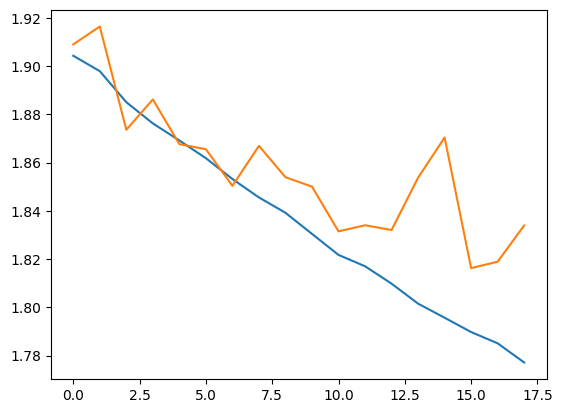

In [28]:
validation_loss
train_loss = [sum(x[1])/len(x[1]) for x in training_loss]
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()


In [ ]:
# 验证多任务训练在 单一任务上的表现 是否有提升
# 人脸平均绝对值误差 单任务        全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.135152058410645
# 人脸平均绝对值误差 均方差 多任务 全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.84007318687439
# 人脸交叉熵损失  单任务          全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 11.208772300338746
# 人脸交叉熵损失 均方差  多任务   全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 13.04701942062378

In [17]:

criterion = RNetLoss()

model.eval() 
val_loss_acc = 0
val_num = 0
with torch.no_grad():
    for inputs in val_loader:
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        loss = criterion(facedet, bbox, landmark, label, ltypes)

        val_loss_acc += loss.item()
        val_num += 1

        print(val_num,loss.item(),val_loss_acc/val_num, val_num*32, len(val_dataset))

print("val loss avg:", val_loss_acc/val_num)


1 2.4574203491210938 2.4574203491210938 32 14898
2 3.728027582168579 3.0927239656448364 64 14898
3 2.540447235107422 2.9086317221323648 96 14898
4 4.25405216217041 3.244986832141876 128 14898
5 2.640634775161743 3.1241164207458496 160 14898
6 3.4796533584594727 3.1833725770314536 192 14898
7 3.8111813068389893 3.27305953843253 224 14898
8 2.943222761154175 3.2318299412727356 256 14898
9 2.8454060554504395 3.188893953959147 288 14898
10 4.184516429901123 3.2884562015533447 320 14898
11 2.820634603500366 3.2459269653667104 352 14898
12 3.61151385307312 3.2763925393422446 384 14898
13 2.7772486209869385 3.2379968533149133 416 14898
14 3.4744904041290283 3.2548892498016357 448 14898
15 2.5700762271881104 3.2092350482940675 480 14898
16 1.8705722093582153 3.1255686208605766 512 14898
17 3.4135985374450684 3.1425115571302524 544 14898
18 4.062824726104736 3.193640066517724 576 14898
19 2.4672329425811768 3.155408112626327 608 14898
20 3.650832414627075 3.180179327726364 640 14898
21 3.298667

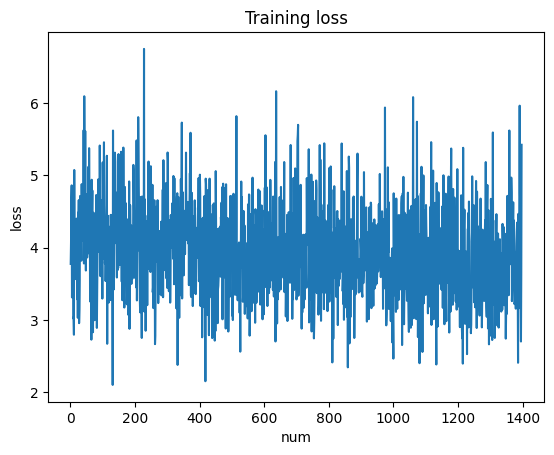

In [18]:
# draw loss curve
plt.plot(training_loss[1][0], training_loss[1][1], label='train')
plt.xlabel('num')
plt.ylabel('loss')
plt.title('Training loss')
plt.show()



In [29]:
# 保存模型
torch.save(model, 'face_loc_r_nn.pth')

In [125]:
# load model
model_trained = torch.load('face_loc_r_48.pth')
model_trained.eval()  # 设置模型为评估/测试模式


RNet(
  (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(48, 64, kernel_size=(2, 2), stride=(1, 1))
  (linear1): Linear(in_features=576, out_features=128, bias=True)
  (face_det): Linear(in_features=128, out_features=2, bias=True)
  (bbox): Linear(in_features=128, out_features=4, bias=True)
  (landmark): Linear(in_features=128, out_features=10, bias=True)
)

In [126]:
aa = iter(test_loader)

In [133]:

a, b, c = next(aa)

In [134]:
def get_argsn(b):
    return [int(float(x)//1) for x in b]

def is_face(i):
    if i == "0":
        return "face"
    if i == "1":
        return "face"
    if i == "2":
        return "not face"
    if i == "3":
        return "not face"
    if i == "4":
        return "not face"
    if i == "5":
        return "face"

In [135]:
right = 0
total = 0
for i in range(128):

    #visualize_transformed_image(a[i],get_argsn(b[i]),get_argsn(b[i]))
    #print(is_face(c[i]))

    with torch.no_grad():
        face_det, bbox, landmark = model_trained(a[i].to(device))
    probabilities = torch.nn.functional.softmax(face_det, dim=1)
    # print(bbox)
    # print(landmark)
    print(probabilities)

    # if probabilities[0][0] > probabilities[0][1]:
    #     print("face")
    #     visualize_transformed_image(a[i],get_argsn(bbox[0]),get_argsn(landmark[0]))   
    # else:
    #     print("not face")
    #     visualize_transformed_image(a[i],[0,0,0,0],None)
    if probabilities[0][0] > 0.8 and is_face(c[i]) == "face":
        right += 1
    if probabilities[0][0] <= 0.2 and is_face(c[i]) == "not face":
        right += 1

    total += 1

print("total: {}".format(total))
print("right: {}".format(right))
print("accuracy: {}".format(right/128))

tensor([[0.2195, 0.7805]], device='cuda:0')
tensor([[0.0763, 0.9237]], device='cuda:0')
tensor([[0.9904, 0.0096]], device='cuda:0')
tensor([[0.9565, 0.0435]], device='cuda:0')
tensor([[0.1128, 0.8872]], device='cuda:0')
tensor([[0.9132, 0.0868]], device='cuda:0')
tensor([[0.0495, 0.9505]], device='cuda:0')
tensor([[0.9941, 0.0059]], device='cuda:0')
tensor([[0.9540, 0.0460]], device='cuda:0')
tensor([[0.0084, 0.9916]], device='cuda:0')
tensor([[0.9477, 0.0523]], device='cuda:0')
tensor([[0.5705, 0.4295]], device='cuda:0')
tensor([[0.0867, 0.9133]], device='cuda:0')
tensor([[0.0132, 0.9868]], device='cuda:0')
tensor([[0.0058, 0.9942]], device='cuda:0')
tensor([[0.9909, 0.0091]], device='cuda:0')
tensor([[0.0097, 0.9903]], device='cuda:0')
tensor([[9.9956e-01, 4.4021e-04]], device='cuda:0')
tensor([[0.0084, 0.9916]], device='cuda:0')
tensor([[0.0187, 0.9813]], device='cuda:0')
tensor([[0.9603, 0.0397]], device='cuda:0')
tensor([[0.9953, 0.0047]], device='cuda:0')
tensor([[0.1848, 0.8152]

In [56]:
def get_argsn(b):
    return [int(float(x)//1) for x in b]

def is_face(i):
    if i == "0":
        return "face"
    if i == "1":
        return "face"
    if i == "2":
        return "not face"
    if i == "3":
        return "not face"
    if i == "4":
        return "not face"
    if i == "5":
        return "face"
    
# load model
model_trained = torch.load('face_loc_r_1_NN.pth')
model_trained.eval()  # 设置模型为评估/测试模式
test_dataset = iter(test_loader)

right = 0
total = 0
for a,b,c in test_dataset:
    try:
        for i in range(128):

            with torch.no_grad():
                face_det, bbox, landmark = model_trained(a[i].to(device))
            probabilities = F.softmax(face_det, dim=1)

            if probabilities[0][0] > probabilities[0][1] and is_face(c[i]) == "face":
                right += 1
            if probabilities[0][0] < probabilities[0][1] and is_face(c[i]) == "not face":
                right += 1

            total += 1
    except:
        pass

print("total: {}".format(total))
print("right: {}".format(right))
print("accuracy: {}".format(right/total))

FileNotFoundError: [Errno 2] No such file or directory: 'face_loc_r_1_NN.pth'